# Solving for Gravity Potential using 2D FFT

In [1]:
import numpy as np
import matplotlib.pyplot as plt


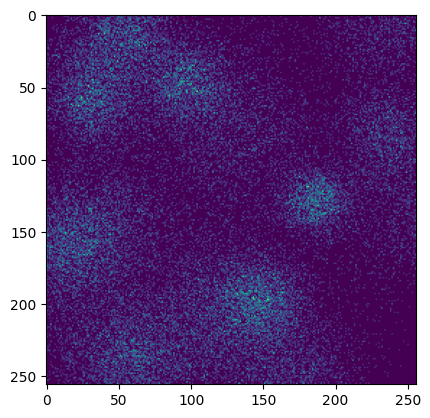

In [2]:
def sample_galaxy(rate = 256, n_galaxies = 20, n_particles_per_galaxy=2000, seed=0):
    np.random.seed(seed)
    grid = np.zeros((rate, rate))

    particles = np.zeros((n_particles_per_galaxy * n_galaxies, 2))
    for i in range(n_galaxies):
        galaxy = np.random.normal(0, np.random.rand()*0.1+0.05, (n_particles_per_galaxy,2))
        galaxy += np.random.rand(2)- 0.5
        galaxy *= rate
        galaxy += rate/2
        particles[i*n_particles_per_galaxy : (i+1) * n_particles_per_galaxy] = galaxy
    
    # nearest grid point mass assignment
    for particle in particles:
        x = int(particle[0])
        y = int(particle[1])
        if x < 0 or x >= rate or y < 0 or y >= rate:
            continue
        grid[x, y] += 1

    return grid

plt.imshow(sample_galaxy())



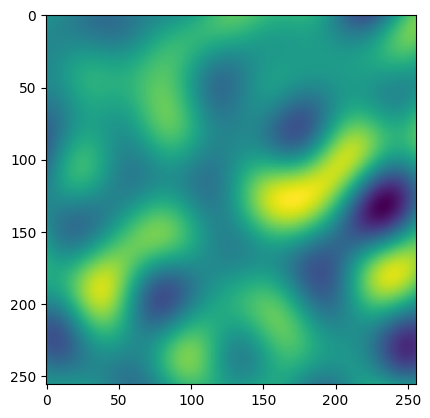

In [3]:


def sample_patterns(rate=256, seed=0, n_patterns=20):
    np.random.seed(seed)

    indices = np.meshgrid(np.arange(0, 1, 1/rate), np.arange(0, 1, 1/rate))
    grid = np.zeros((rate, rate))

    for i in range(n_patterns):
        angle = np.random.rand() * 2 * np.pi
        indices_angled = indices.copy()
        indices_angled[0] = indices[0] * np.cos(angle) - indices[1] * np.sin(angle)
        indices_angled[1] = indices[0] * np.sin(angle) + indices[1] * np.cos(angle)

        indices_angled = np.sum(indices_angled, axis=0)

        grid += np.sin(indices_angled*np.random.rand()*20)

    return grid


plt.imshow(sample_patterns())
    


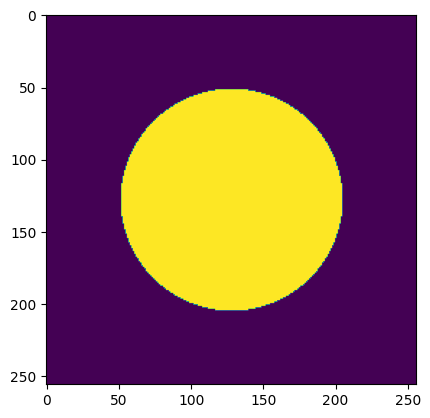

In [4]:
def sample_circle(rate=256):
    indices = np.array(np.meshgrid(np.arange(-0.5, 0.5, 1/rate), np.arange(-0.5, 0.5, 1/rate)))
    grid = np.zeros((rate, rate))

    grid = np.sqrt(np.sum(indices**2, axis=0)) < 0.3

    return grid

plt.imshow(sample_circle())

In [5]:
def fft_1d(signal):
    N = len(signal)
    if N == 1:
        return signal
    else:
        n = np.arange(N)
        X_even = fft_1d(signal[::2])
        X_odd = fft_1d(signal[1::2])
        factor = np.exp(-2j*np.pi*n/ N)
        X = np.concatenate(\
            [X_even+factor[:int(N/2)]*X_odd,
             X_even+factor[int(N/2):]*X_odd])
        return X

def fft_2d(signal):
    n_rows, n_cols = signal.shape

    y = np.zeros((n_rows, n_cols), dtype=np.complex128)
    for row in range(n_rows):
        y[row, :] = fft_1d(signal[row, :])

    y = y.T

    for row in range(n_rows):
        y[row, :] = fft_1d(y[row, :])

    y = y.T

    return y

def shift_2d(signal):
    n_rows, n_cols = signal.shape
    nyquist = n_cols // 2
    y = np.zeros((n_rows, n_cols), dtype=np.complex128)
    y[:, :nyquist] = signal[:, nyquist:]
    y[:, nyquist:] = signal[:, :nyquist]

    y[:nyquist, :] = y[:nyquist, :][::-1, :]
    y[nyquist:, :] = y[nyquist:, :][::-1, :]

    return y


In [6]:
frequency_galaxy = fft_2d(sample_galaxy())
frequency_patterns = fft_2d(sample_patterns())
frequency_circle = fft_2d(sample_circle())

(96.0, 160.0)

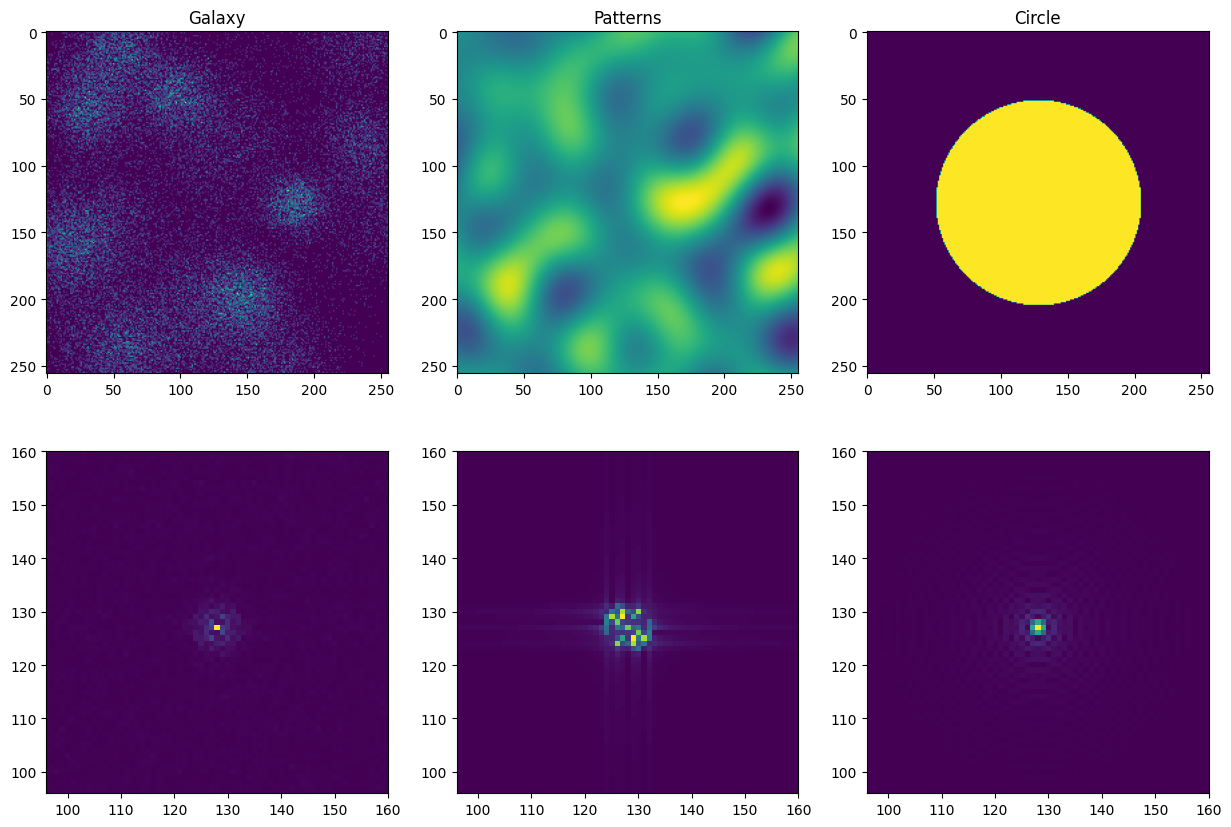

In [7]:
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(15, 10)

axs[0, 0].imshow(sample_galaxy())
axs[0, 1].imshow(sample_patterns())
axs[0, 2].imshow(sample_circle())

frequency_galaxy_shifted = shift_2d(frequency_galaxy)
frequency_patterns_shifted = shift_2d(frequency_patterns)   
frequency_circle_shifted = shift_2d(frequency_circle)

axs[1, 0].imshow(np.abs(frequency_galaxy_shifted))
axs[1, 1].imshow(np.abs(frequency_patterns_shifted))
axs[1, 2].imshow(np.abs(frequency_circle_shifted))
 
axs[0, 0].set_title("Galaxy")
axs[0, 1].set_title("Patterns")
axs[0, 2].set_title("Circle")

axs[1,0].set_xlim(96, 160)
axs[1,0].set_ylim(96, 160)
axs[1,1].set_xlim(96, 160)
axs[1,1].set_ylim(96, 160)
axs[1,2].set_xlim(96, 160)
axs[1,2].set_ylim(96, 160)

In [8]:

def ifft_1d(signal):
    N = len(signal)
    if N == 1:
        return signal
    else:
        n = np.arange(N)
        X_even = ifft_1d(signal[::2])
        X_odd = ifft_1d(signal[1::2])
        factor = np.exp(2j*np.pi*n/ N)
        X = np.concatenate(\
            [X_even+factor[:int(N/2)]*X_odd,
             X_even+factor[int(N/2):]*X_odd])
        return X
    
def ifft_2d(signal):
    n_rows, n_cols = signal.shape

    y = np.zeros((n_rows, n_cols), dtype=np.complex128)
    for row in range(n_rows):
        y[row, :] = ifft_1d(signal[row, :])

    y = y.T

    for row in range(n_rows):
        y[row, :] = ifft_1d(y[row, :])

    y = y.T

    return y

In [22]:
def get_potential(x):
    n = x.shape[0]
    rho = np.mean(x)

    # get delta rho from x
    x = x - rho
    # obtain delta rho from x
    x = fft_2d(x)

    x = -x 

    kx, ky = np.meshgrid(np.fft.fftfreq(x.shape[0]), np.fft.fftfreq(x.shape[1]))
    x = -x / (4 * np.pi**2 * (kx**2 + ky**2))

    print(x.shape)
    print(kx.shape)
    print(ky.shape)

    x[np.logical_or(kx == 0, ky == 0)] = 0

    # Apply the inverse 2D FFT to get the real-space potential
    x = np.real(ifft_2d(x))

    return x


In [23]:
potential_galaxy = get_potential(sample_galaxy())
potential_patterns = get_potential(sample_patterns())
potential_circle = get_potential(sample_circle())

/tmp/ipykernel_357/722826820.py:13: RuntimeWarning: invalid value encountered in divide
  x = -x / (4 * np.pi**2 * (kx**2 + ky**2))


(256, 256)
(256, 256)
(256, 256)


/tmp/ipykernel_357/722826820.py:13: RuntimeWarning: divide by zero encountered in divide
  x = -x / (4 * np.pi**2 * (kx**2 + ky**2))


(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)


(96.0, 160.0)

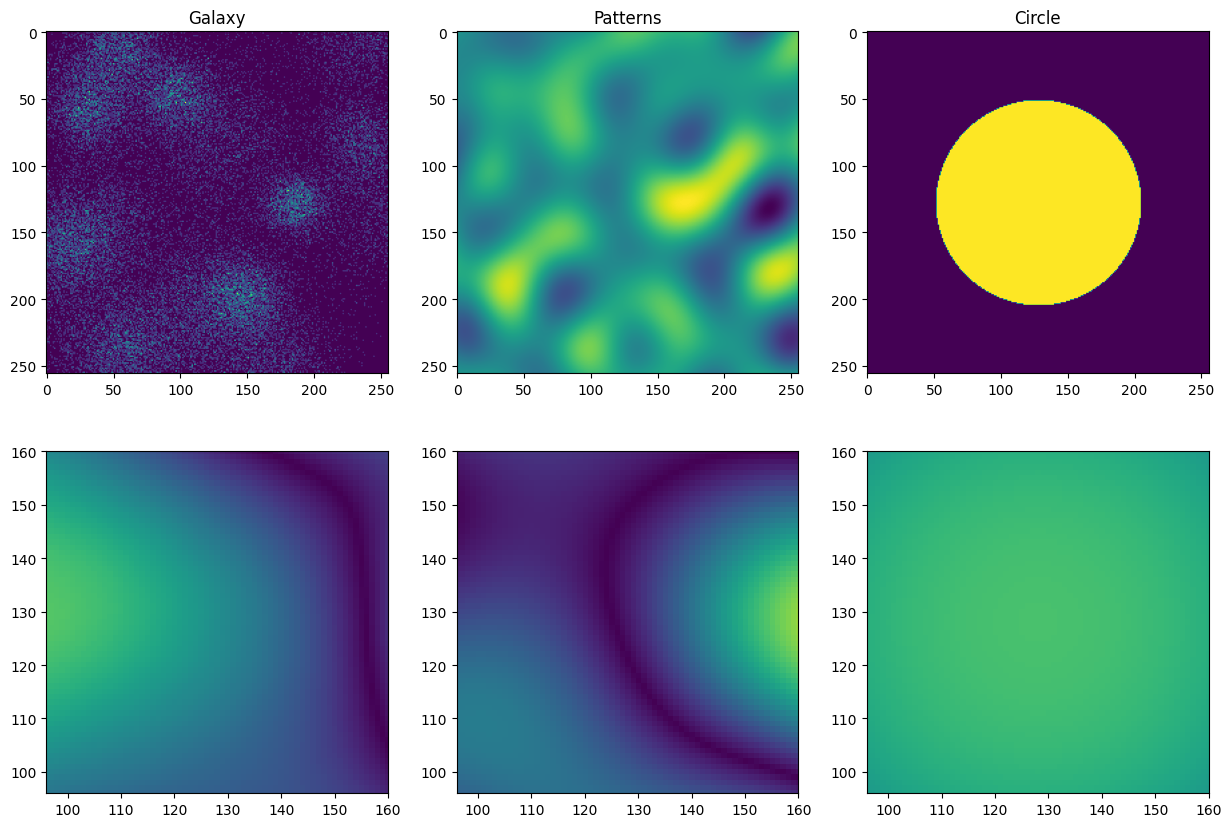

In [24]:
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(15, 10)

axs[0, 0].imshow(sample_galaxy())
axs[0, 1].imshow(sample_patterns())
axs[0, 2].imshow(sample_circle())

axs[1, 0].imshow(np.abs(potential_galaxy))
axs[1, 1].imshow(np.abs(potential_patterns))
axs[1, 2].imshow(np.abs(potential_circle))
 
axs[0, 0].set_title("Galaxy")
axs[0, 1].set_title("Patterns")
axs[0, 2].set_title("Circle")
